In [1]:
import numpy as np
import essentia
import essentia.standard as es
from scipy.signal import hilbert
import utils as u
import matplotlib.pyplot as plt

SSL_DSET_PATH = '/Volumes/Production Tools/coding_projs/THESIS/data_preprocesses/data/Diff-SSL-G-Comp'
DRY_PATH = '/processed_normalized'
WET_PATH = '/processed_ground_truth'

SR = 44100

# Hilbert Envelope vs RMS

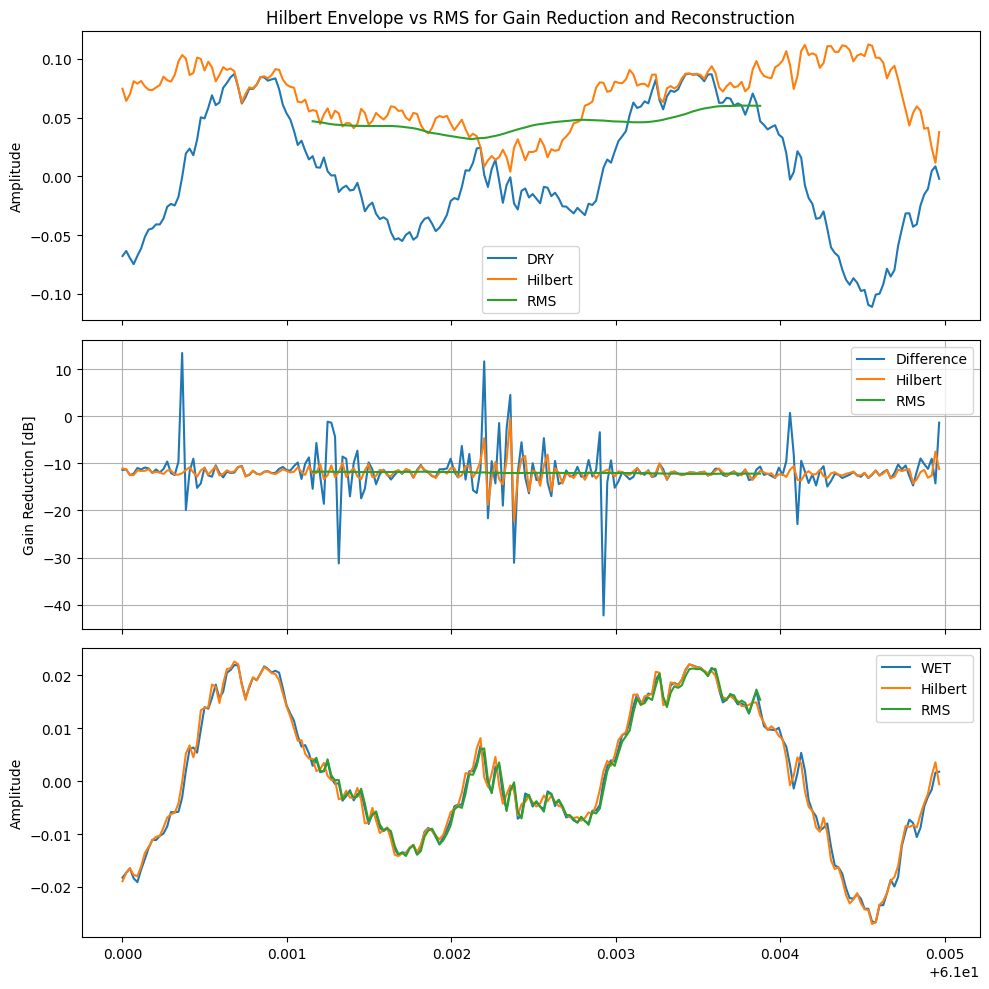

In [15]:
t_start = 61
t_length = 0.005
window_size = 100

# Load dry audio
path = SSL_DSET_PATH+DRY_PATH+'/NosPalpitants_UnmasteredWAV.wav'
t, audio = u.load_audio(path, cut=(t_start, t_start+t_length))

# Load wet audio
path_wet = SSL_DSET_PATH+WET_PATH+'/threshold_-12_attack_30_release_0.4_ratio_10/NosPalpitants-exported.wav'
t, audio_wet = u.load_audio(path_wet, cut=(t_start, t_start+t_length))

# compute difference
diff = audio_wet / audio

# Compute envelopes for dry signal
analytic_signal = hilbert(audio)
amplitude_envelope_pre_dB = np.abs(analytic_signal)
amplitude_envelope = u.to_dB(amplitude_envelope_pre_dB)
t_rms, rms = u.window_rms(t, audio, window_size, in_dB=False)
rms_dB = u.to_dB(rms)

# Compute envelopes for wet signal
analytic_signal_wet = hilbert(audio_wet)
amplitude_envelope_wet_pre_dB = np.abs(analytic_signal_wet)
amplitude_envelope_wet = u.to_dB(amplitude_envelope_wet_pre_dB)
t_rms_wet, rms_wet = u.window_rms(t, audio_wet, window_size, in_dB=False)
rms_wet_dB = u.to_dB(rms_wet)

# Compute gain reduction in dB
gr_dB = amplitude_envelope_wet - amplitude_envelope
gr_rms_dB = rms_wet_dB - rms_dB

# Convert gain reduction to amplitude
gr = u.to_amplitude(gr_dB)
gr_rms = u.to_amplitude(gr_rms_dB)

# Recreate signals by applying gain reduction
recreated_signal = audio * gr
recreated_signal_rms = audio[window_size//2:-window_size//2+1] * gr_rms

# PLOTTING
fig, ax = plt.subplots(nrows=3, sharex='all', tight_layout=True, figsize=(10, 10))
ax[0].set_title("Hilbert Envelope vs RMS for Gain Reduction and Reconstruction")
ax[0].set_ylabel("Amplitude")
ax[0].plot(t, audio, label='DRY')
ax[0].plot(t, amplitude_envelope_pre_dB, label='Hilbert')
ax[0].plot(t_rms, rms, label='RMS')
ax[0].legend()

ax[1].set_ylabel("Gain Reduction [dB]")
ax[1].plot(t, u.to_dB(np.abs(diff)), label='Difference')
ax[1].plot(t, gr_dB, label='Hilbert')
ax[1].plot(t_rms, gr_rms_dB, label='RMS')
ax[1].grid()
ax[1].legend()

ax[2].set_ylabel("Amplitude")
ax[2].plot(t, audio_wet, label='WET')
ax[2].plot(t, recreated_signal, label='Hilbert')
ax[2].plot(t_rms, recreated_signal_rms, label='RMS')
ax[2].legend()

plt.show()

# Loss

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [11]:
signal_wet = torch.as_tensor(audio_wet[window_size//2+1:-window_size//2+2], dtype=torch.float32)
signal_hilbert = torch.as_tensor(recreated_signal[window_size//2+1:-window_size//2+2], dtype=torch.float32)
signal_rms = torch.as_tensor(recreated_signal_rms, dtype=torch.float32)

loss_function = nn.L1Loss()
loss_hilbert = loss_function(signal_hilbert, signal_wet)
loss_rms = loss_function(signal_rms, signal_wet)

print(f"Loss Hilbert: {loss_hilbert.item()}")
print(f"Loss RMS: {loss_rms.item()}")


Loss Hilbert: 0.0009314635535702109
Loss RMS: 0.0005580591969192028


In [ ]:
def FRAC_LOSS(dry_pred, wet_pred, dry_target, wet_target):
    